In [1]:
# from google.colab import drive
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
from google.colab import drive

drive.mount('/content/drive')
# Create a directory in Drive for Hugging Face cache
HF_CACHE_DIR = "/content/drive/MyDrive/hf_cache"
os.makedirs(HF_CACHE_DIR, exist_ok=True)

# Set environment variable so Hugging Face uses this cache
os.environ["TRANSFORMERS_CACHE"] = HF_CACHE_DIR

Mounted at /content/drive


In [3]:
cd drive/MyDrive/dataliteracy25

/content/drive/MyDrive/dataliteracy25


## Download XML files of parliament sittings
For first test: used only sitings for 10th parliament (2024-2029), all sittings in october 25

In [ ]:
from scripts.xml_scrapper import get_all_sittings
get_all_sittings(out_folder="data/xml", months=[10])

CRE-10-2025-10-01_EN.xml  - Failed
CRE-10-2025-10-02_EN.xml  - Failed
CRE-10-2025-10-03_EN.xml  - Failed
CRE-10-2025-10-04_EN.xml  - Failed
CRE-10-2025-10-05_EN.xml  - Failed
CRE-10-2025-10-06_EN.xml  - OK
CRE-10-2025-10-07_EN.xml  - OK
CRE-10-2025-10-08_EN.xml  - OK
CRE-10-2025-10-09_EN.xml  - OK
CRE-10-2025-10-10_EN.xml  - Failed
CRE-10-2025-10-11_EN.xml  - Failed
CRE-10-2025-10-12_EN.xml  - Failed
CRE-10-2025-10-13_EN.xml  - Failed
CRE-10-2025-10-14_EN.xml  - Failed
CRE-10-2025-10-15_EN.xml  - Failed
CRE-10-2025-10-16_EN.xml  - Failed
CRE-10-2025-10-17_EN.xml  - Failed
CRE-10-2025-10-18_EN.xml  - Failed
CRE-10-2025-10-19_EN.xml  - Failed
CRE-10-2025-10-20_EN.xml  - OK
CRE-10-2025-10-21_EN.xml  - OK
CRE-10-2025-10-22_EN.xml  - OK
CRE-10-2025-10-23_EN.xml  - OK
CRE-10-2025-10-24_EN.xml  - Failed
CRE-10-2025-10-25_EN.xml  - Failed
CRE-10-2025-10-26_EN.xml  - Failed
CRE-10-2025-10-27_EN.xml  - Failed
CRE-10-2025-10-28_EN.xml  - Failed
CRE-10-2025-10-29_EN.xml  - Failed
CRE-10-2025-10-30

Process XML files to CSV

In [10]:
from scripts.xml_reader import parse_contributions
import json

color_map = json.load(open("data/party_maps/colors_10.json"))
valid_groups = color_map.keys()

SUBFOLDER = "/migration"

os.makedirs(f"data/csv/10{SUBFOLDER}", exist_ok=True)

In [ ]:
for root, dirs, files in os.walk(f"data/xml/10{SUBFOLDER}"):
    for f in files:
        print(f)
        contributions = parse_contributions(f"{root}/{f}")

        df = pd.DataFrame(contributions)

        df = df[df["PP"].isin(valid_groups)]

        df.to_csv(f"data/csv/10{SUBFOLDER}/{f.replace('.xml', '.csv')}")

## Embedd sitings

In [4]:
# Load model directly
from transformers import AutoModel
model = AutoModel.from_pretrained("jinaai/jina-embeddings-v4", trust_remote_code=True, torch_dtype="auto").to("cuda")

/usr/local/lib/python3.12/dist-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
A new version of the following files was downloaded from https://huggingface.co/jinaai/jina-embeddings-v4:
- configuration_jina_embeddings_v4.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, y

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_config.json:   0%|          | 0.00/900 [00:00<?, ?B/s]

adapters/adapter_model.safetensors:   0%|          | 0.00/360M [00:00<?, ?B/s]

In [5]:
def embedd_speech(speeches):
    embeddings = model.encode_text(texts=speeches, task="text-matching", prompt_name="query", return_numpy=True)
    return embeddings

In [10]:
# for speedup (and because of GPU memory limits), limit number of characters per speech
SPEECH_CHAR_LIMIT = 500
os.makedirs(f"data/embeddings/10{SUBFOLDER}", exist_ok=True)

for root, dirs, files in os.walk(f"data/csv/10{SUBFOLDER}"):
    for f in files:
        df = pd.read_csv(f"{root}/{f}")

        speeches_capped = df['speech'].map(lambda s: s[:SPEECH_CHAR_LIMIT])
        embeddings = embedd_speech(speeches_capped.to_list())

        np.save(f"data/embeddings/10{SUBFOLDER}/{f.replace(".csv", ".npy")}", embeddings)

Encoding texts...: 100%|██████████| 6/6 [00:33<00:00,  5.61s/it]


## Cluster speeches

In [ ]:
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import json

PARLIAMENT_CYLCE = 10

color_map = json.load(open(f"data/party_maps/colors_{PARLIAMENT_CYLCE}.json"))
os.makedirs(f"data/plots/{PARLIAMENT_CYLCE}{SUBFOLDER}", exist_ok=True)

def reduce_and_cluster(embeddings, n_components=2, n_clusters=9):
  pca = PCA(n_components=n_components)
  reduced = pca.fit_transform(embeddings)

  kmeans = KMeans(n_clusters=n_clusters, random_state=42)
  labels = kmeans.fit_predict(reduced)

  # kmeans = KMeans(n_clusters=n_clusters, random_state=42)
  # labels = kmeans.fit_predict(embeddings)
  
  return reduced, labels

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Circle

def plot_cluster_ellipses(X, labels, cluster_names, ax):
    # plot an ellipse around each cluster; chatgpt generated, naturally
    unique_labels = np.unique(labels)
    for k in unique_labels:
        cluster_points = X[labels == k]
        mean = cluster_points.mean(axis=0)
        if len(cluster_points) == 1:
          patch = Circle(mean, 0.01, fill=False, color="black")
          width, height = 1, 1
          # cluster is only 1 point => draw circle
        else:
          # Eigen-decomposition for ellipse axes
          cov = np.cov(cluster_points, rowvar=False)
          vals, vecs = np.linalg.eigh(cov)
          order = vals.argsort()[::-1]
          vals, vecs = vals[order], vecs[:, order]

          theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
          width, height = 2 * np.sqrt(vals) * 2  # scale factor for visibility

          patch = Ellipse(xy=mean, width=width, height=height,
                            angle=theta, edgecolor='black', fc='none', lw=1)
        ax.add_patch(patch)

        if cluster_names is not None:
          # Compute label position: top-left corner of ellipse
          offset_x = -width / 2.5
          offset_y = height / 2.5
          ax.text(mean[0] + offset_x, mean[1] + offset_y, cluster_names[k],
                  fontsize=10, ha='left', va='bottom')

def plot_clusters(title, reduced, labels, parties, cluster_names, filename):
  fig, ax = plt.subplots(figsize=(10, 8))
  plt.title(title)
  plot_cluster_ellipses(reduced, labels,cluster_names, ax)

  colors = [color_map[p] for p in parties]
  ax.scatter(reduced[:,0], reduced[:,1], c=colors, s=40)

  # plt.legend(*scatter.legend_elements(), title="Cluster")
  plt.savefig(f"data/plots/{PARLIAMENT_CYLCE}{SUBFOLDER}/{filename}")

/var/folders/mn/w4hb6knd0w93tgscwpwq9dp00000gn/T/ipykernel_23410/1013093846.py:47: RuntimeWarning: invalid value encountered in sqrt
  width, height = 2 * np.sqrt(vals) * 2  # scale factor for visibility
/var/folders/mn/w4hb6knd0w93tgscwpwq9dp00000gn/T/ipykernel_23410/1013093846.py:47: RuntimeWarning: invalid value encountered in sqrt
  width, height = 2 * np.sqrt(vals) * 2  # scale factor for visibility


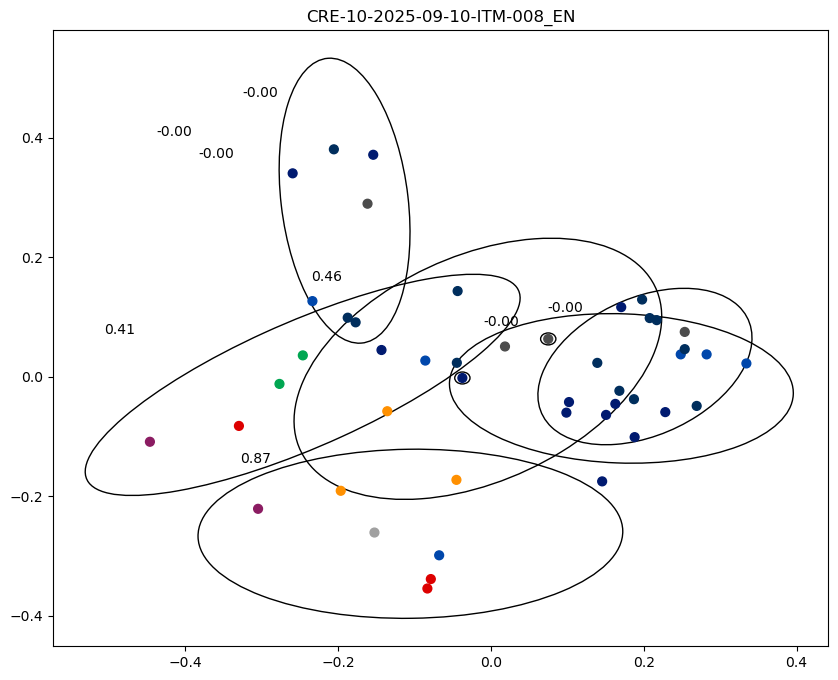

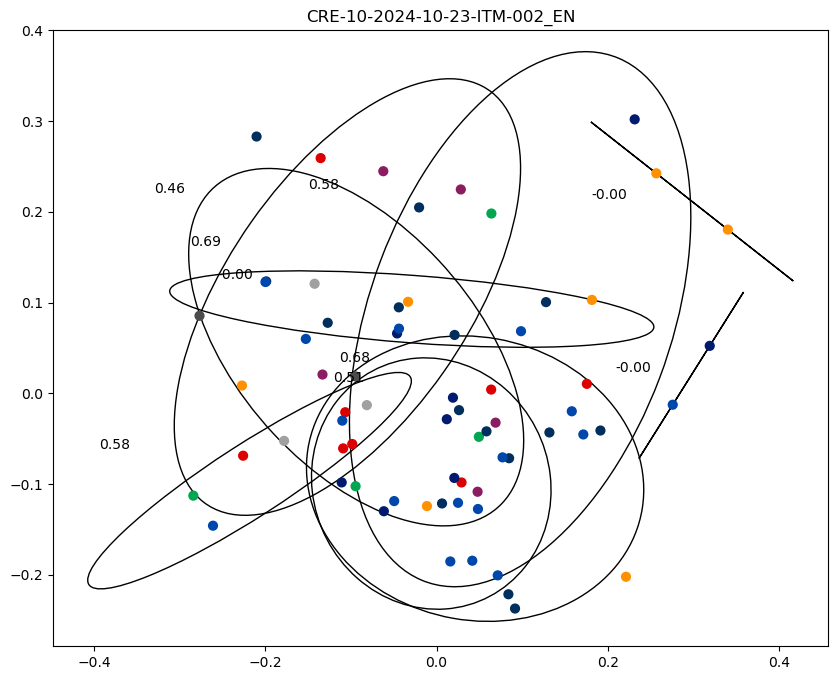

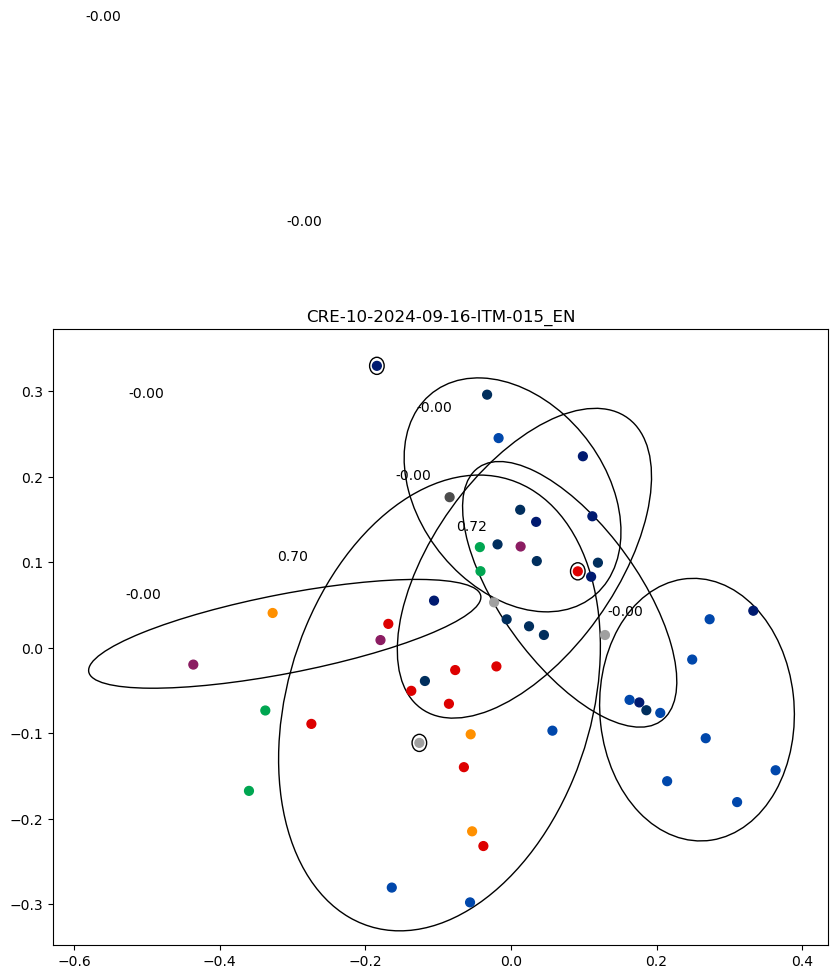

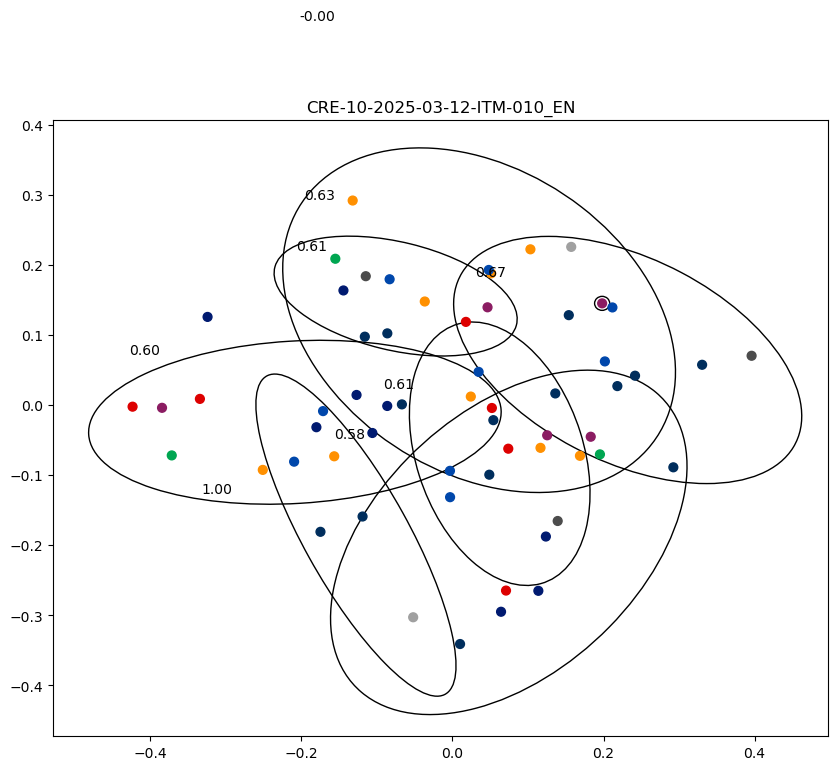

In [ ]:
def cluster_noise(row):
    # calculate entropy per cluster (chatgpt generated lol)
    values = row.values
    probs = values / values.sum() if values.sum() > 0 else np.zeros_like(values)
    entropy = -np.sum([p * np.log(p) for p in probs if p > 0])
    norm_entropy = entropy / np.log(len(probs))
    return norm_entropy

def noise_per_cluster(df, column):
    # one hot encode column (party / party orientation)
    column_one_hot = pd.get_dummies(df[column])
    df = df.join(column_one_hot)
    df = df.groupby("cluster").sum()

    noise_per_cluster = df[[*column_one_hot.columns]].apply(cluster_noise, axis=1)
    return noise_per_cluster

party_orientations = json.load(open(f"data/party_maps/orientations_{PARLIAMENT_CYLCE}.json"))

for root, dirs, files in os.walk(f"data/csv/{PARLIAMENT_CYLCE}{SUBFOLDER}"):
    for f in files:
        df = pd.read_csv(f"{root}/{f}")
        embeddings = np.load(f"data/embeddings/{PARLIAMENT_CYLCE}{SUBFOLDER}/{f.replace(".csv", ".npy")}")

        if f == "CRE-9-2021-11-23-ITM-010_EN.csv":
            # the initial test contained one noise item at the end => remove it here, only to be able to plot this
            df = df[:-1]
            embeddings = embeddings[:-1]

        reduced, labels = reduce_and_cluster(embeddings, n_clusters=len(color_map.keys()))

        # analyse the cluster consistency:
        # how homogenous are party memberships per cluster
        # one hot encode parties => then group by clusters
        df["cluster"] = labels
        df["orientation"] = df.apply(lambda x: party_orientations[x["PP"]], axis=1)
        
        cluster_noises = noise_per_cluster(df, "orientation") # cluster => noise
        cluster_noises = cluster_noises.map(lambda x: f"{x:.2f}")

        plot_clusters(f.replace(".csv", ""), reduced, labels, df["PP"], cluster_noises, f.replace(".csv", "_pca_after.svg"))


In [ ]:
# for root, dirs, files in os.walk(f"data/csv/{PARLIAMENT_CYLCE}{SUBFOLDER}"):
#     for f in files:
#         df = pd.read_csv(f"{root}/{f}")
        
#         for party in df
#         df[]